In [1]:
import pickle
# 导入向量化后的数据集
np_vectorized_doc2vec = pickle.load(open('model/vectorized_generated_corpus_TWDoc2vec.pkl', 'rb'))

In [2]:
# 读入正确标签（Labels）
labels = []
# 读入数据集
with open('sixTypes-GeneratedLabels.txt', 'r', encoding='utf-8') as f:
    for line in f.readlines():
        labels.append(line.strip('\n'))

In [3]:
# 利用 RandomizedSearchCV 搜索不同的 维度 和 gamma 值来找到最优解（利用 V-measure 评估）

# Import required libraries
from sklearn.model_selection import RandomizedSearchCV
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.metrics import v_measure_score

# Define the parameter values that want to search
param_grid = {
    'lle__n_components': range(2, 11),
    'lle__n_neighbors': range(2, 31),
    'kmeans__n_clusters': range(6, 7)
}

# Define a scoring function that takes in y_true and y_pred as arguments and returns the v_measure_score
def v_measure_scorer(estimator, X, y_true):
    y_pred = estimator.predict(X)
    return v_measure_score(y_true, y_pred)

# Create a randomize search object
# 注意，此处初始化时加了 eigen_solver='dense'，否则可能报错
lle = LocallyLinearEmbedding(eigen_solver='dense')
kmeans = KMeans()
model = Pipeline([('lle', lle), ('kmeans', kmeans)])
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=10, cv=5, random_state=9, scoring=v_measure_scorer, verbose=3, error_score='raise')

# Fit the random search object to the data
random_search.fit(np_vectorized_doc2vec, labels)

# Get the best estimator
best_estimator = random_search.best_estimator_
print('best_estimator', best_estimator)

# Use the best estimator to make predictions
y_pred = best_estimator.predict(np_vectorized_doc2vec)

# Use V-measure to evaluate the clustering results
score = v_measure_score(labels, y_pred)
print('V-measure:', score)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END kmeans__n_clusters=6, lle__n_components=3, lle__n_neighbors=27;, score=0.326 total time=   0.3s
[CV 2/5] END kmeans__n_clusters=6, lle__n_components=3, lle__n_neighbors=27;, score=0.663 total time=   0.2s
[CV 3/5] END kmeans__n_clusters=6, lle__n_components=3, lle__n_neighbors=27;, score=0.539 total time=   0.2s
[CV 4/5] END kmeans__n_clusters=6, lle__n_components=3, lle__n_neighbors=27;, score=0.070 total time=   0.2s
[CV 5/5] END kmeans__n_clusters=6, lle__n_components=3, lle__n_neighbors=27;, score=0.385 total time=   0.2s
[CV 1/5] END kmeans__n_clusters=6, lle__n_components=7, lle__n_neighbors=23;, score=0.526 total time=   0.2s
[CV 2/5] END kmeans__n_clusters=6, lle__n_components=7, lle__n_neighbors=23;, score=0.788 total time=   0.2s
[CV 3/5] END kmeans__n_clusters=6, lle__n_components=7, lle__n_neighbors=23;, score=0.652 total time=   0.2s
[CV 4/5] END kmeans__n_clusters=6, lle__n_components=7, lle__n_neig

In [4]:
from sklearn.manifold import LocallyLinearEmbedding
# 选用最优解 n_neighbors 与 维度数 用 LLE 降维
lle = LocallyLinearEmbedding(n_components=7, n_neighbors=9)
decomposition_data = lle.fit_transform(np_vectorized_doc2vec)

In [5]:
from sklearn.manifold import LocallyLinearEmbedding
# 画散点图之前，首先用 LLE 降维，不输入 n_neighbors 时默认为 5
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=9)
decomposition_data_2d = lle.fit_transform(np_vectorized_doc2vec)

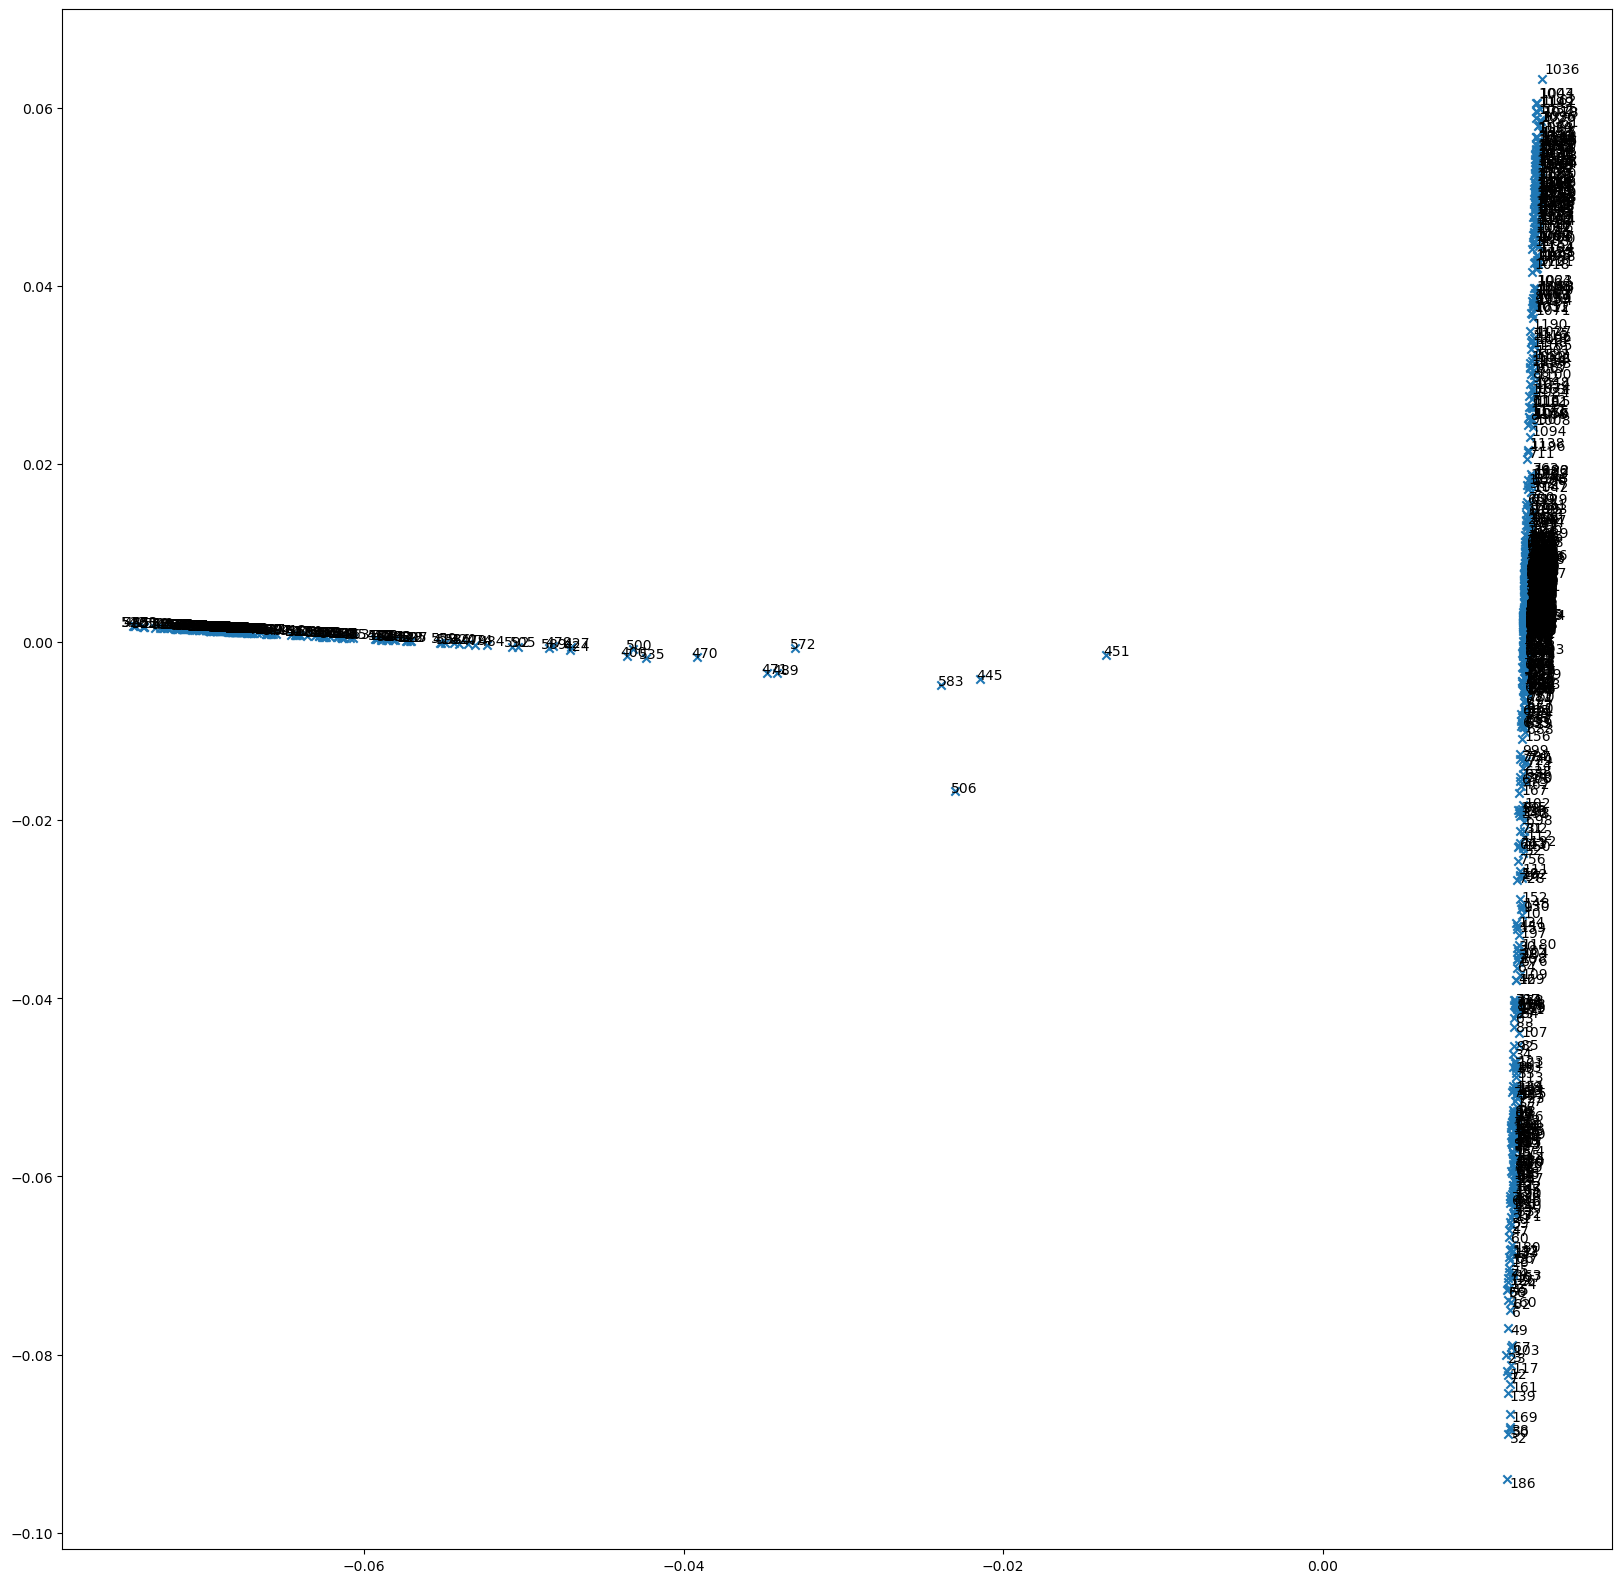

In [6]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 20))
ax = plt.axes()
plt.scatter(decomposition_data_2d[:, 0], decomposition_data_2d[:, 1], marker='x')
for i in range(len(decomposition_data_2d)):
    plt.text(decomposition_data_2d[:, 0][i] * 1.01, decomposition_data_2d[:, 1][i] * 1.01, i, fontsize=10)
plt.show()

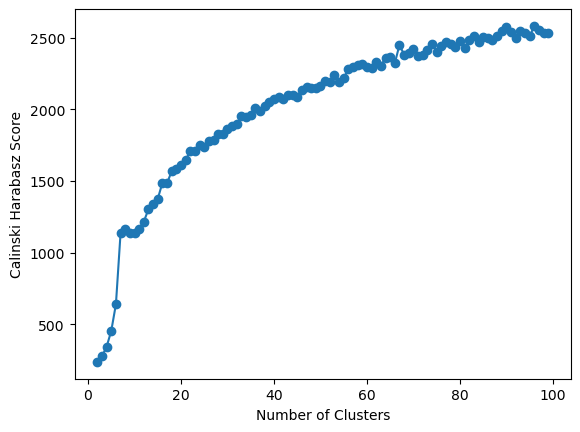

In [7]:
# K-means 算法聚类并利用 Calinski Harabasz Score 评估效果
from sklearn.cluster import KMeans
from sklearn import metrics
calinski_harabasz_score_list = []
for n_cluster in range(2, 100):
    y_pred = KMeans(n_clusters=n_cluster, init='k-means++', random_state=9).fit_predict(decomposition_data)
    current_score = metrics.calinski_harabasz_score(decomposition_data, y_pred)
    calinski_harabasz_score_list.append(current_score)

plt.plot(range(2,100), calinski_harabasz_score_list, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski Harabasz Score')
plt.show()

In [8]:
calinski_harabasz_score_list.index(max(calinski_harabasz_score_list))

94

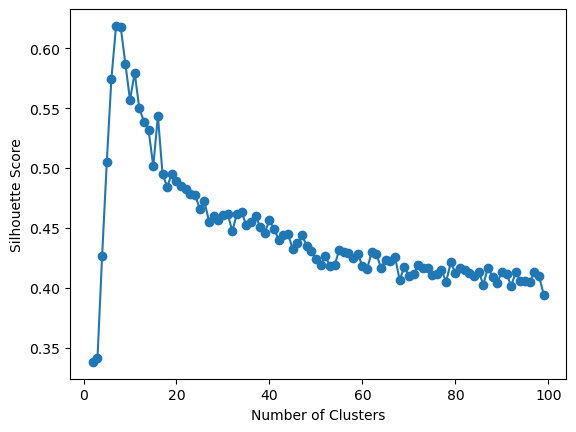

In [9]:
# K-means 算法聚类并利用 Silhouette Score（轮廓系数）评估效果
silhouette_score_list = []
for n_cluster in range(2, 100):
    km = KMeans(n_clusters=n_cluster, random_state=9)
    y_pred = km.fit_predict(decomposition_data)
    current_score = metrics.silhouette_score(decomposition_data, km.labels_ , metric='euclidean')
    silhouette_score_list.append(current_score)

plt.plot(range(2,100), silhouette_score_list, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [10]:
silhouette_score_list.index(max(silhouette_score_list))

5

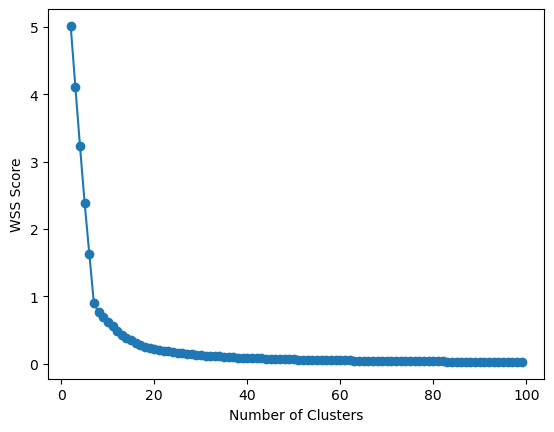

In [11]:
# K-means 算法聚类并利用 WSS（Within-cluster Sum of Squares）评估效果
WSS_score_list = []
for n_cluster in range(2, 100):
    km = KMeans(n_clusters=n_cluster, random_state=9)
    y_pred = km.fit_predict(decomposition_data)
    current_score = km.inertia_
    WSS_score_list.append(current_score)

plt.plot(range(2,100), WSS_score_list, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WSS Score')
plt.show()

In [12]:
# 选用 k 值做 K-means 算法聚类
y_pred = KMeans(n_clusters=6, init='k-means++', random_state=9).fit_predict(decomposition_data)

In [13]:
print(y_pred[:10])

[5 5 5 5 1 5 5 5 5 5]


In [14]:
import numpy as np
# 用 dict 统计出所有类别的坐标
y_pred_dict = {}
for i in range(len(decomposition_data_2d)):
    if y_pred[i] not in y_pred_dict:
        y_pred_dict[y_pred[i]] = decomposition_data_2d[i].reshape(1, 2)
    else:
        y_pred_dict[y_pred[i]] = np.vstack((y_pred_dict[y_pred[i]], decomposition_data_2d[i]))

In [15]:
for key, value in y_pred_dict.items():
    print(key, value[:, 0].mean())

5 0.011960073368646152
1 0.013340524768586416
4 0.012655553109130316
2 0.012841146635137432
0 0.012738634665355006
3 -0.0645646809514746


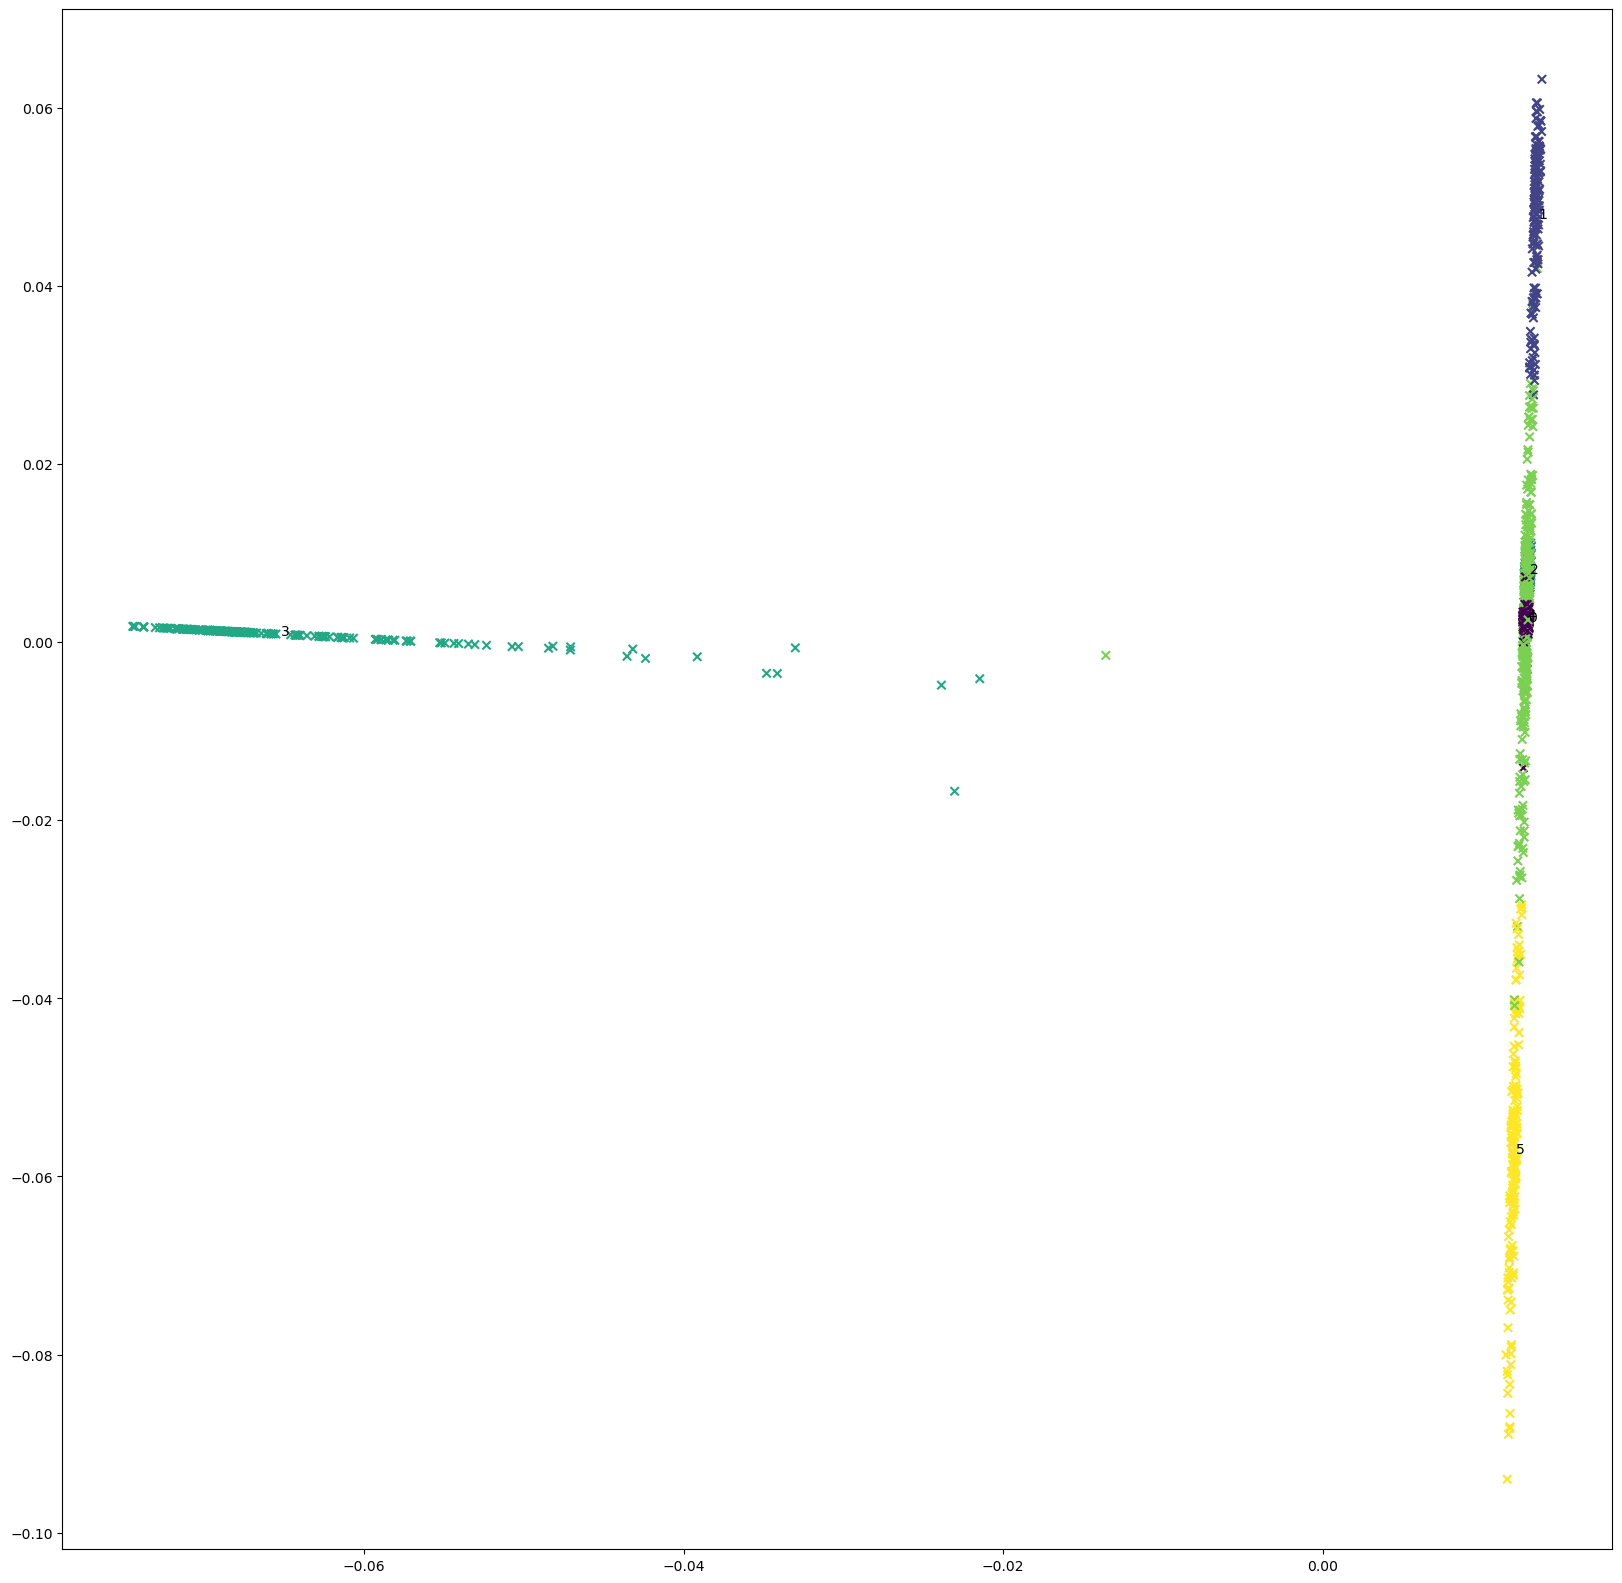

In [18]:
fig = plt.figure(figsize=(20, 20))
ax = plt.axes()
plt.scatter(decomposition_data_2d[:, 0], decomposition_data_2d[:, 1], c=y_pred, marker='x')
for key, value in y_pred_dict.items():
    plt.text(value[:, 0].mean() * 1.01, value[:, 1].mean() * 1.01, key, fontsize=10)
plt.show()

In [19]:
# 利用 Calinski Harabasz Score 评估当前 K-Means 聚类效果（利用 Word2vec 表征）
metrics.calinski_harabasz_score(decomposition_data, y_pred)

638.8613266643725

In [20]:
# 利用 Silhouette Score（轮廓系数）评估当前 K-Means 聚类效果（利用 Word2vec 表征）
km = KMeans(n_clusters=6, random_state=9)
y_pred = km.fit_predict(decomposition_data)
metrics.silhouette_score(decomposition_data, km.labels_, metric='euclidean')

0.5746769228294049

In [21]:
# 读入正确标签（Labels）
labels = []
# 读入数据集
with open('sixTypes-GeneratedLabels.txt', 'r', encoding='utf-8') as f:
    for line in f.readlines():
        labels.append(line.strip('\n'))

In [22]:
labels[:10]

['CP', 'CP', 'CP', 'CP', 'CP', 'CP', 'CP', 'CP', 'CP', 'CP']

In [23]:
# 利用 Homogeneity 评估当前 K-Means 聚类效果（利用 Word2vec 表征）
metrics.homogeneity_score(labels, y_pred)

0.7289376810443903

In [24]:
# 利用 Completeness 评估当前 K-Means 聚类效果（利用 Word2vec 表征）
metrics.completeness_score(labels, y_pred)

0.7574029460147312

In [25]:
# 利用 V-measure 评估当前 K-Means 聚类效果（利用 Word2vec 表征）
metrics.v_measure_score(labels, y_pred)

0.7428977409795408

In [26]:
# 利用 Adjusted Rand Index（调整兰德系数）评估当前 K-Means 聚类效果（利用 Word2vec 表征）
metrics.adjusted_rand_score(labels, y_pred)

0.6275368437305998

In [27]:
# 利用 Adjusted Mutual Information Score（调整互信息）评估当前 K-Means 聚类效果（利用 Word2vec 表征）
metrics.adjusted_mutual_info_score(labels, y_pred)

0.7413533371856611

In [28]:
# 利用 Fowlkes-Mallows scores 评估当前 K-Means 聚类效果（利用 Word2vec 表征）
metrics.fowlkes_mallows_score(labels, y_pred)

0.6957827056479678